In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.engine.topology import Layer
from keras import backend as K
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from utils import LRN2D
import utils

%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


In [18]:
myInput = Input(shape=(96, 96, 3))

x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)
x = Lambda(LRN2D, name='lrn_1')(x)
x = Conv2D(64, (1, 1), name='conv2')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = Conv2D(192, (3, 3), name='conv3')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
x = Activation('relu')(x)
x = Lambda(LRN2D, name='lrn_2')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)

# Inception3a
inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
inception_3a_pool = Activation('relu')(inception_3a_pool)
inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

# Inception3b
inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

inception_3b_pool = Lambda(lambda x: x**2, name='power2_3b')(inception_3a)
inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3b_pool)
inception_3b_pool = Lambda(lambda x: x*9, name='mult9_3b')(inception_3b_pool)
inception_3b_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_3b')(inception_3b_pool)
inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
inception_3b_pool = Activation('relu')(inception_3b_pool)
inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

# Inception3c
inception_3c_3x3 = utils.conv2d_bn(inception_3b,
                                   layer='inception_3c_3x3',
                                   cv1_out=128,
                                   cv1_filter=(1, 1),
                                   cv2_out=256,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(2, 2),
                                   padding=(1, 1))

inception_3c_5x5 = utils.conv2d_bn(inception_3b,
                                   layer='inception_3c_5x5',
                                   cv1_out=32,
                                   cv1_filter=(1, 1),
                                   cv2_out=64,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(2, 2),
                                   padding=(2, 2))

inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

#inception 4a
inception_4a_3x3 = utils.conv2d_bn(inception_3c,
                                   layer='inception_4a_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=192,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))
inception_4a_5x5 = utils.conv2d_bn(inception_3c,
                                   layer='inception_4a_5x5',
                                   cv1_out=32,
                                   cv1_filter=(1, 1),
                                   cv2_out=64,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(1, 1),
                                   padding=(2, 2))

inception_4a_pool = Lambda(lambda x: x**2, name='power2_4a')(inception_3c)
inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4a_pool)
inception_4a_pool = Lambda(lambda x: x*9, name='mult9_4a')(inception_4a_pool)
inception_4a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_4a')(inception_4a_pool)
inception_4a_pool = utils.conv2d_bn(inception_4a_pool,
                                   layer='inception_4a_pool',
                                   cv1_out=128,
                                   cv1_filter=(1, 1),
                                   padding=(2, 2))
inception_4a_1x1 = utils.conv2d_bn(inception_3c,
                                   layer='inception_4a_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))
inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

#inception4e
inception_4e_3x3 = utils.conv2d_bn(inception_4a,
                                   layer='inception_4e_3x3',
                                   cv1_out=160,
                                   cv1_filter=(1, 1),
                                   cv2_out=256,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(2, 2),
                                   padding=(1, 1))
inception_4e_5x5 = utils.conv2d_bn(inception_4a,
                                   layer='inception_4e_5x5',
                                   cv1_out=64,
                                   cv1_filter=(1, 1),
                                   cv2_out=128,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(2, 2),
                                   padding=(2, 2))
inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

#inception5a
inception_5a_3x3 = utils.conv2d_bn(inception_4e,
                                   layer='inception_5a_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=384,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))

inception_5a_pool = Lambda(lambda x: x**2, name='power2_5a')(inception_4e)
inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_5a_pool)
inception_5a_pool = Lambda(lambda x: x*9, name='mult9_5a')(inception_5a_pool)
inception_5a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_5a')(inception_5a_pool)
inception_5a_pool = utils.conv2d_bn(inception_5a_pool,
                                   layer='inception_5a_pool',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   padding=(1, 1))
inception_5a_1x1 = utils.conv2d_bn(inception_4e,
                                   layer='inception_5a_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))

inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

#inception_5b
inception_5b_3x3 = utils.conv2d_bn(inception_5a,
                                   layer='inception_5b_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=384,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))
inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
inception_5b_pool = utils.conv2d_bn(inception_5b_pool,
                                   layer='inception_5b_pool',
                                   cv1_out=96,
                                   cv1_filter=(1, 1))
inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

inception_5b_1x1 = utils.conv2d_bn(inception_5a,
                                   layer='inception_5b_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))
inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
reshape_layer = Flatten()(av_pool)
dense_layer = Dense(128, name='dense_layer')(reshape_layer)
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)


# Final Model
model = Model(inputs=[myInput], outputs=norm_layer)

In [19]:
# Load weights from csv files (which was exported from Openface torch model)
weights = utils.weights
weights_dict = utils.load_weights()

# Set layer weights of the model
for name in weights:
  if model.get_layer(name) != None:
    model.get_layer(name).set_weights(weights_dict[name])
  elif model.get_layer(name) != None:
    model.get_layer(name).set_weights(weights_dict[name])

In [31]:
def image_to_embedding(image, model):
    #image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_AREA) 
    image = cv2.resize(image, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (0,1,2))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding


In [26]:
import glob

def create_input_image_embeddings():       #  # Change folder --> folder 
    input_embeddings = {}

    for file in glob.glob("imagesv1/*"):
        for file1 in glob.glob(file+"/*"):
            person_name_image = os.path.splitext(os.path.basename(file1))[0]
            person_name = os.path.splitext(os.path.basename(file))[0]
#             print(person_name)
            image_file = cv2.imread(file1, 1)
            input_embeddings[person_name,person_name_image] = image_to_embedding(image_file, model)

    return input_embeddings

In [33]:
create_input_image_embeddings()

{('Abhay',
  'Abhay1'): array([[-0.05665346,  0.09382   ,  0.10575874, -0.00410809, -0.02910287,
          0.23073658, -0.08054958, -0.08437497,  0.0190839 , -0.08848883,
          0.01988362, -0.04445106, -0.04967446, -0.15188852,  0.08992682,
         -0.03482782, -0.20911153, -0.00198642, -0.03044993, -0.0461389 ,
          0.05998567,  0.03016513,  0.03750049,  0.02175034,  0.01813793,
          0.05248685, -0.0656314 , -0.1871005 ,  0.01231395, -0.0904211 ,
          0.18941805,  0.00195943, -0.0297968 ,  0.06218548,  0.16793986,
          0.14279321,  0.03260726,  0.02036742,  0.01894297, -0.03978714,
          0.11002897, -0.13040523, -0.06754488,  0.04854063, -0.05804337,
          0.01509884,  0.13143015,  0.03719434, -0.1926749 , -0.01528703,
         -0.12796636, -0.02214747,  0.08391976, -0.00699371,  0.04520389,
          0.07514625, -0.01990008,  0.05377021, -0.07943652, -0.1366547 ,
         -0.1340704 ,  0.07408836,  0.1659325 , -0.1150014 ,  0.14974162,
          0.076

In [34]:
emb = create_input_image_embeddings()

In [35]:
for (name,arr) in emb.items():
    print(name[0])

Abhay
Abhay
Abhay
Abhinav
Abhinav


In [69]:
# Create a new folder
from datetime import datetime
date_time = str(datetime.now().strftime('%Y%m%d%H%M%S'))
newpath = r'C:\Users\Abhay\Desktop\Face-recognition-using-deep-learning-master\imagesv1\newUser'+date_time
image_path = r'imagesv1\newUser'+date_time
newpath = str(newpath)
print(image_path)
# if not os.path.exists(newpath):
#     os.makedirs(newpath)

imagesv1\newUser20190124184108


In [60]:
# to get current time and date

from datetime import datetime
date_time = datetime.now().strftime('%Y-%m-%d_(%H:%M:%S)')

In [61]:
print(date_time)

2019-01-24_(18:33:39)


In [1]:
st = input("Enter name")
print(st)

Enter nameAbhay
Abhay


In [168]:
import glob
def create_input_image_embeddings():       #  # Change folder --> folder 
    input_embeddings = {}
    input_embeddings_first_image = {}

    for file in glob.glob("imagesv1/*"):
        i = 0
        for file1 in glob.glob(file+"/*"):
            person_name_image = os.path.splitext(os.path.basename(file1))[0]
            person_name = os.path.splitext(os.path.basename(file))[0]
#             print(person_name)
            image_file = cv2.imread(file1, 1)
            input_embeddings[person_name,person_name_image] = image_to_embedding(image_file, model)
            if i==0:
                input_embeddings_first_image[person_name,person_name_image] = image_to_embedding(image_file, model)
                i=1
            
                
    return input_embeddings,input_embeddings_first_image

In [169]:
def recognize_face(input_embeddings_first_image, input_embeddings,euclidean_distance_limit):   #  # change aso using cosine distance

#     embedding = image_to_embedding(face_image, model)
    
   
    name = None
    tp = 1
    tn = 1
    fp = 1
    fn = 1
    # Loop over  names and encodings.
    

    for(test_name,test_embedding) in input_embeddings_first_image.items():
        for (input_name, input_embedding) in input_embeddings.items():
            euclidean_distance = np.linalg.norm(test_embedding-input_embedding)
        
    #             a = np.matmul(embedding,input_embedding.T)
    #             b = np.sqrt(np.matmul(embedding,embedding.T))
    #             c = np.sqrt(np.matmul(input_embedding,input_embedding.T))
    #             cosine_dist = a / ( b * c )
        
    #             #print(dist1)
    #             print (cosine_dist)
        
      
                  #print('Euclidean distance from %s is %s' %(input_name, euclidean_distance))

                #print(input_name[0],test_name[0])
            if euclidean_distance < euclidean_distance_limit and test_name[0] == input_name[0] :
                    #(predicted positive, actual positive) (True_Positive)
                
                tp = tp + 1                        
                          
            if euclidean_distance < euclidean_distance_limit and test_name[0] != input_name[0] :
                    #(predicted positive, actual negative) (False_Positive)
                fp = fp + 1
#                 print(test_name[0] , input_name[0], euclidean_distance, euclidean_distance_limit)
                    
            if euclidean_distance > euclidean_distance_limit and test_name[0] == input_name[0] :
                    #(predicted negative, actual positive) (False_Negative)
                fn = fn + 1
                    
            if euclidean_distance > euclidean_distance_limit and test_name[0] != input_name[0] :
                    #(predicted negative, actual negative) (True_negative)
                tn = tn + 1
                        
           
        
    return tp,fp,fn,tn
    

In [178]:
#Work on precision and F-score
import matplotlib.pyplot as plt
%matplotlib inline
def optimizing_th():

#     dict_tp = {}
#     dict_tn = {}
#     dict_fp = {}
#     dict_fn = {}
    f1_score = {}
    precision = {}
    recall = {}
    
    input_embeddings,input_embeddings_first_image = create_input_image_embeddings()
    euclidean_distance_limit = 0
    while euclidean_distance_limit < 1.5:
        tp,fp,fn,tn = recognize_face(input_embeddings_first_image, input_embeddings,euclidean_distance_limit)
#         print('limit = %s  tp = %s' %(euclidean_distance_limit, tp))
        
#         dict_tp.update({euclidean_distance_limit:tp})
#         dict_fp.update({euclidean_distance_limit:fp})
#         dict_fn.update({euclidean_distance_limit:fn})
#         dict_tn.update({euclidean_distance_limit:tn})

        p = tp/(tp + fp)
        r = tp/(tp + fn)
        precision.update({euclidean_distance_limit : p})
        recall.update({euclidean_distance_limit : r})
        f1 = 2 * (p * r) / (p + r)
        f1_score.update({euclidean_distance_limit : tp/(tp + fn)})
           
        euclidean_distance_limit = round(euclidean_distance_limit + 0.001,3)
        print('limit = %s  p = %s r = %s' %(euclidean_distance_limit, p,r))
   
    print(len(f1_score))
    
  

In [179]:
 optimizing_th()



limit = 0.001  p = 0.5 r = 0.125
limit = 0.002  p = 0.8 r = 0.36363636363636365
limit = 0.003  p = 0.8 r = 0.36363636363636365
limit = 0.004  p = 0.8 r = 0.36363636363636365
limit = 0.005  p = 0.8 r = 0.36363636363636365
limit = 0.006  p = 0.8 r = 0.36363636363636365
limit = 0.007  p = 0.8 r = 0.36363636363636365
limit = 0.008  p = 0.8 r = 0.36363636363636365
limit = 0.009  p = 0.8 r = 0.36363636363636365
limit = 0.01  p = 0.8 r = 0.36363636363636365
limit = 0.011  p = 0.8 r = 0.36363636363636365
limit = 0.012  p = 0.8 r = 0.36363636363636365
limit = 0.013  p = 0.8 r = 0.36363636363636365
limit = 0.014  p = 0.8 r = 0.36363636363636365
limit = 0.015  p = 0.8 r = 0.36363636363636365
limit = 0.016  p = 0.8 r = 0.36363636363636365
limit = 0.017  p = 0.8 r = 0.36363636363636365
limit = 0.018  p = 0.8 r = 0.36363636363636365
limit = 0.019  p = 0.8 r = 0.36363636363636365
limit = 0.02  p = 0.8 r = 0.36363636363636365
limit = 0.021  p = 0.8 r = 0.36363636363636365
limit = 0.022  p = 0.8 r = 0.

limit = 0.33  p = 0.8 r = 0.36363636363636365
limit = 0.331  p = 0.8 r = 0.36363636363636365
limit = 0.332  p = 0.8 r = 0.36363636363636365
limit = 0.333  p = 0.8 r = 0.36363636363636365
limit = 0.334  p = 0.8 r = 0.36363636363636365
limit = 0.335  p = 0.8 r = 0.36363636363636365
limit = 0.336  p = 0.8 r = 0.36363636363636365
limit = 0.337  p = 0.8 r = 0.36363636363636365
limit = 0.338  p = 0.8 r = 0.36363636363636365
limit = 0.339  p = 0.8 r = 0.36363636363636365
limit = 0.34  p = 0.8 r = 0.36363636363636365
limit = 0.341  p = 0.8 r = 0.36363636363636365
limit = 0.342  p = 0.8 r = 0.36363636363636365
limit = 0.343  p = 0.8 r = 0.36363636363636365
limit = 0.344  p = 0.8 r = 0.36363636363636365
limit = 0.345  p = 0.8 r = 0.36363636363636365
limit = 0.346  p = 0.8 r = 0.36363636363636365
limit = 0.347  p = 0.8 r = 0.36363636363636365
limit = 0.348  p = 0.8 r = 0.36363636363636365
limit = 0.349  p = 0.8 r = 0.36363636363636365
limit = 0.35  p = 0.8 r = 0.36363636363636365
limit = 0.351  p

limit = 0.679  p = 0.75 r = 0.5454545454545454
limit = 0.68  p = 0.75 r = 0.5454545454545454
limit = 0.681  p = 0.75 r = 0.5454545454545454
limit = 0.682  p = 0.75 r = 0.5454545454545454
limit = 0.683  p = 0.75 r = 0.5454545454545454
limit = 0.684  p = 0.75 r = 0.5454545454545454
limit = 0.685  p = 0.75 r = 0.5454545454545454
limit = 0.686  p = 0.75 r = 0.5454545454545454
limit = 0.687  p = 0.75 r = 0.5454545454545454
limit = 0.688  p = 0.75 r = 0.5454545454545454
limit = 0.689  p = 0.75 r = 0.5454545454545454
limit = 0.69  p = 0.75 r = 0.5454545454545454
limit = 0.691  p = 0.75 r = 0.5454545454545454
limit = 0.692  p = 0.75 r = 0.5454545454545454
limit = 0.693  p = 0.75 r = 0.5454545454545454
limit = 0.694  p = 0.6666666666666666 r = 0.5454545454545454
limit = 0.695  p = 0.6666666666666666 r = 0.5454545454545454
limit = 0.696  p = 0.6666666666666666 r = 0.5454545454545454
limit = 0.697  p = 0.6666666666666666 r = 0.5454545454545454
limit = 0.698  p = 0.6666666666666666 r = 0.545454545

limit = 1.024  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.025  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.026  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.027  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.028  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.029  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.03  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.031  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.032  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.033  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.034  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.035  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.036  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.037  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.038  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1.039  p = 0.38461538461538464 r = 0.9090909090909091
limit = 1

limit = 1.281  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.282  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.283  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.284  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.285  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.286  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.287  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.288  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.289  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.29  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.291  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.292  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.293  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.294  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.295  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.296  p = 0.3448275862068966 r = 0.9090909090909091
limit = 1.297  p = 0.3448

In [126]:
 x = ['a','a','b','b','b','d']
a={1:85,2:8}
a.update({8:7})
b = a.keys()
c= a.values()

In [127]:
print(c)

dict_values([85, 8, 7])


In [129]:
%matplotlib inline
import random
import sys
import array
plt.figure(figsize=(10,8))
plt.title('Scatter Plot', fontsize=20)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.scatter(xs, ys, marker = 'o')
for  x,y in b,c:
    plt.annotate(x, y)

NameError: name 'plt' is not defined

In [17]:
# find most occuring string from list

from collections import Counter
count = Counter(x)
count
freq_list = count.values()
freq_list
count.most_common()[0][0]

'b'

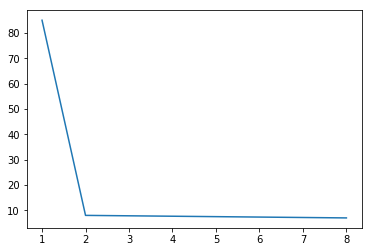

In [6]:
 
for i in range (0,10,0.1):
    print(i)

TypeError: 'float' object cannot be interpreted as an integer

In [50]:
1 != 2

True

In [1]:
import cv2
import numpy as np
 
im = cv2.imread('aaa.jpg')
im = im/255.0
im_power_law_transformation = cv2.pow(im,0.6)
cv2.imshow('Original Image',im)
cv2.imshow('Power Law Transformation',im_power_law_transformation)
cv2.waitKey(0)

error: OpenCV(4.0.0) C:\projects\opencv-python\opencv\modules\highgui\src\window_w32.cpp:1230: error: (-215:Assertion failed) dst.data == (uchar*)dst_ptr in function 'cvShowImage'


In [2]:
import numpy as np
def gamma(image,gamma = 0.5):
    img_float = np.float32(image)
    max_pixel = np.max(img_float)
    #image pixel normalisation
    img_normalised = img_float/max_pixel
    #gamma correction exponent calulated
    gamma_corr = np.log(img_normalised)*gamma
    #gamma correction being applied
    gamma_corrected = np.exp(gamma_corr)*255.0
    #conversion to unsigned int 8 bit
    gamma_corrected = np.uint8(gamma_corrected)
    return gamma_corrected


def logt(image):
    img_float = np.float32(image)
    max_pixel = np.max(img_float)
    #log correction being caluclated
    log_corrected = (255.0*np.log(1+img_float))/np.log(1+max_pixel)
    #conversion to unsigned int 8 bit
    log_corrected = np.uint8(log_corrected)
    return log_correctedenter 
def histogram_equal(image):
    img_float = np.float32(image)
    #conversion 2D array to 1D array
    img_flat = img_float.flatten()
    #histogram genreation
    hist,bins = np.histogram(img_float,256,[0,255])
    #histogram cumulative distribution
    cdf = hist.cumsum()
    #to ignore values of cdf = 0
    cdf_masked = np.ma.masked_equal(cdf,0)
    num_cdf_m = (cdf_masked - cdf_masked.min())*255
    den_cdf_m = (cdf_masked.max()-cdf_masked.min())
    cdf_masked = num_cdf_m/den_cdf_m
    cdf = np.ma.filled(cdf_masked,0)
    cdf = np.uint8(cdf)
    img_flat = np.uint8(img_flat)
    img = cdf[img_flat]
    img = np.reshape(img,img_float.shape)
    return img   

In [4]:
histogram_equal("aaa.jpg")

ValueError: could not convert string to float: 'aaa.jpg'

In [1]:
import cv2
import numpy as np 
img = cv2.imread("aaa.jpg")


# cv2.imshow("Img",img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [6]:
from __future__ import print_function
import numpy as np
import argparse
import cv2
 
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [7]:
adjust_gamma("aaa.jpg")

TypeError: Expected cv::UMat for argument 'src'

In [10]:
import cv2
import numpy as np

img1 = cv2.imread('aaa.jpg')
a = np.double(img1)
b = a + 15
img2 = np.uint8(b)
cv2.imshow("frame",img1)
cv2.imshow("frame2",img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [17]:
# GAMMA CORRECTION

import cv2
import numpy as np
import imageio

def adjust_gamma(image, gamma=1):

   invGamma = 1.0 / gamma
   table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

x = 'C:/Users/Abhay/Desktop/Face-recognition-using-deep-learning-master/aad.jpg'  
original = cv2.imread(x, 1)
cv2.imshow('original',original)

gamma = 2.5                                
adjusted = adjust_gamma(original, gamma=gamma)
cv2.putText(adjusted, "g={}".format(gamma), (10, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
cv2.imshow("gammam image 1", adjusted)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
# To find image dark or bright
import imageio
import numpy as np

f = imageio.imread('C:/Users/Abhay/Desktop/Face-recognition-using-deep-learning-master/aac.jpg', as_gray=True)

def img_estim(img, thrshld):
    is_light = np.mean(img) > thrshld
    return 'light' if is_light else 'dark'

print(img_estim(f, 127))

dark


In [1]:
import imageio
import cv2
import numpy as np

def img_estim(img, thrshld):
    is_light = np.mean(img) > thrshld
    return 'light' if is_light else 'dark'

def adjust_gamma(image, gamma=1):

   invGamma = 1.0 / gamma
   table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)


def Gamma_correction(image) :
#     f = cv2.imread(image,1)
#     original = cv2.imread(image, 1)
    f = img1
    original = img1
    if img_estim(f, 127) == 'dark' :
        gamma = 2.5
        adjusted = adjust_gamma(original, gamma=gamma)
        return adjusted
    else :
        return original
        

In [7]:
img1 = cv2.imread('aac.jpg')
img = Gamma_correction(img1)#('C:/Users/Abhay/Desktop/Face-recognition-using-deep-learning-master/abe.jpg')
cv2.imwrite('C:/Users/Abhay/Desktop/Face-recognition-using-deep-learning-master/abz.jpg',img)
cv2.imshow("gammam image 1", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [1]:
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import os

Using TensorFlow backend.


In [2]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [3]:
#you can download the pretrained weights from the following link 
#https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#or you can find the detailed documentation https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

from keras.models import model_from_json
model.load_weights('C:/Users/Abhay/Desktop/Face-recognition-using-deep-learning-master/vgg_face_weights.h5')

In [4]:
import imageio
import cv2
import numpy as np

def img_estim(img, thrshld):
    is_light = np.mean(img) > thrshld
    print(np.mean(img))
    return 'light' if is_light else 'dark'

def adjust_gamma(image, gamma=1):

   invGamma = 1.0 / gamma
   table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)


def Gamma_correction(image) :
#     f = cv2.imread(image,1)
    f = image
#     original = cv2.imread(image, 1)
    original = image
    if img_estim(f, 90) == 'dark' :
        print('dark--------')
        gamma = 2.0
        adjusted = adjust_gamma(original, gamma=gamma)
        return adjusted
    else :
        return original
        

In [5]:
def image_to_embedding(image, model):
#     image  =  Gamma_correction(image)
#     image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_AREA) 
    image = cv2.resize(image, (224, 224)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (0,1,2))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding


In [6]:
def recognize_face(face_image, model):   #  # change also using cosine distance

    corrected_face_image = Gamma_correction(face_image) 
    embedding_corrected = image_to_embedding(corrected_face_image, model)
    embedding = image_to_embedding(face_image, model)
    cv2.imshow("Original Image",face_image)
    cv2.imshow("gammam image 1", corrected_face_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    # Loop over  names and encodings.
        
       
    euclidean_distance = np.linalg.norm(embedding-embedding_corrected) * 1000
        
    a = np.matmul(embedding,embedding_corrected.T)
    b = np.sqrt(np.matmul(embedding,embedding.T))
    c = np.sqrt(np.matmul(embedding_corrected,embedding_corrected.T))
    cosine_dist = a / ( b * c )
        
    print(euclidean_distance)
    print (cosine_dist)
        
      
        

In [7]:
img1 = cv2.imread('aae.jpg')
recognize_face(img1, model)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'